# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:22<00:00, 1432.71it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_118904 = final['Summary'].values[118904]
print(sent_118904)
print("="*50)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

A classic


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

DELICIOUS


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [00:55<00:00, 2126.05it/s]


In [34]:
preprocessed_Summary = [118904]
print (preprocessed_Summary)

[118904]


# Time Based Splitting

In [35]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final_20.shape)
final_20.head(3)

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
38084,41359,B0096EZHM2,AVI2RPWTKG4L2,"William Hilger ""jack-of-most-trades""",1,1,1,1332806400,help for diabetic cats,Just found out that my wife's cat has diabetes...,found wife cat diabetes vet prescribed insulin...
115525,125288,B001E5E060,A3NEAETOSXDBOM,Stephen M. Charme,1,1,1,1307318400,Great breakfast cereal,This cereal has it all. It tastes great; each ...,cereal tastes great serving loaded fiber prote...
107655,116859,B001BCVY9W,A3L1MEXXDI4Q77,"Miranda Prince ""Punky Monkey""",0,0,1,1229212800,My Cats Love It,My cats really seem to like this food. It does...,cats really seem like food look like people fo...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [36]:
# sample dataset 
final_20['Score'].value_counts()

1    83945
0    16055
Name: Score, dtype: int64

In [37]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [38]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.228589224540642

In [39]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [40]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (100000,)


In [41]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (100000,)


# [4] Featurization

## [4.3] TF-IDF

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features = 2000).fit(X)
X_tf_idf = tf_idf_vect.transform(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_tf_idf.get_shape())
print("the number of unique words :", X_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'across', 'actual', 'actually', 'add']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (100000, 2000)
the number of unique words : 2000


In [43]:
print("the number of unique words :", X_tf_idf.get_shape()[1])

the number of unique words : 2000


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features = 2000)
X_tf_idf = tf_idf_vect.fit_transform(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_tf_idf.get_shape())
print("the number of unique words :", X_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'across', 'actual', 'actually', 'add']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (100000, 2000)
the number of unique words : 2000


In [45]:
top_2000_words = tf_idf_vect.get_feature_names()

### [5.2] Calulation of Co-occurrence matrix

In [46]:
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix
# https://stackoverflow.com/questions/42814452/co-occurrence-matrix-from-list-of-words-in-python/42814963
# https://codereview.stackexchange.com/questions/185698/calculate-co-occurrences-of-some-words-in-documents-dataset


from tqdm import tqdm
n_neighbor = 5
occ_matrix_2000 = np.zeros((2000,2000))
for row in tqdm(X):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in top_2000_words:
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if words_in_row[j] in top_2000_words:
                    occ_matrix_2000[top_2000_words.index(word),top_2000_words.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [54:44<00:00, 30.45it/s]


### [5.3] Finding optimal value for number of components (n) to be retained.

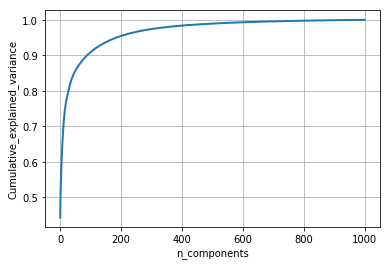

In [47]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
# https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
# https://www.researchgate.net/post/How_do_we_choose_the_best_optimal_k_value_for_truncated_SVD
# https://stackoverflow.com/questions/48424084/number-of-components-trucated-svd


from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
svd = TruncatedSVD(n_components = 1000)
svd_2000 = svd.fit_transform(occ_matrix_2000)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [48]:
svd = TruncatedSVD(n_components = 150)
svd_2000 = svd.fit_transform(occ_matrix_2000)

### [5.4] Applying k-means clustering

# K-Means++ Implementation

In [49]:
# https://www.programcreek.com/python/example/85779/sklearn.cluster.KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
from sklearn.cluster import KMeans

k_values = [2,4,6,8,10,12,14]
inertia = []
for i in tqdm(k_values):
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(svd_2000)
    inertia.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.37s/it]


# Hyper parameter Tuning

# Elbow-knee method (plot k vs inertia_)

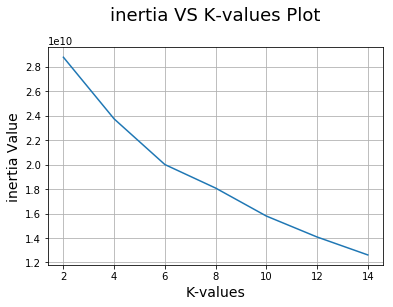

In [50]:
# Draw inertia VS K values plot
plt.plot(k_values, inertia)
plt.xlabel('K-values',size=14)
plt.ylabel('inertia Value',size=14)
plt.title('inertia VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [51]:
optimal_k = 14
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(svd_2000)

In [52]:
# this is the list of clusters
cluster = [ [] for i in range(optimal_k) ]
for i in range(kmeans.labels_.shape[0]):
    cluster[kmeans.labels_[i]].append(X[i])

### [5.5] Wordclouds of clusters obtained in the above section

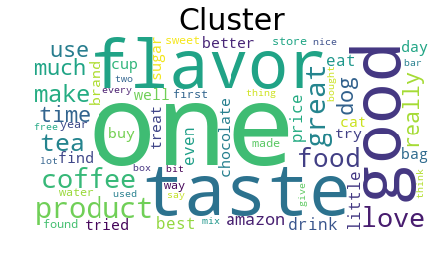

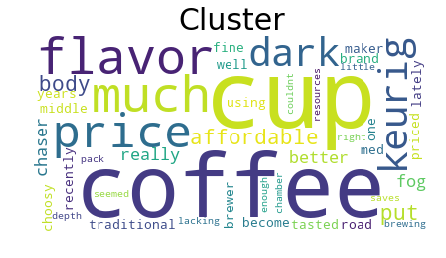

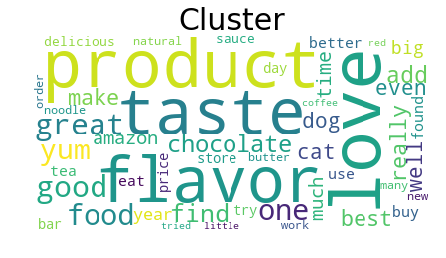

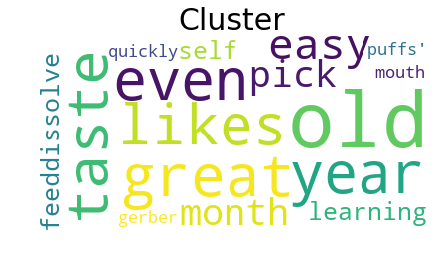

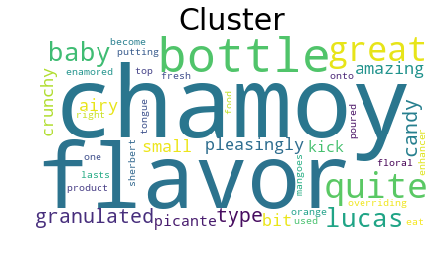

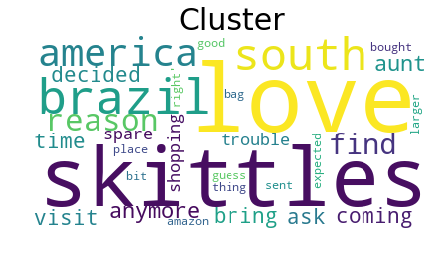

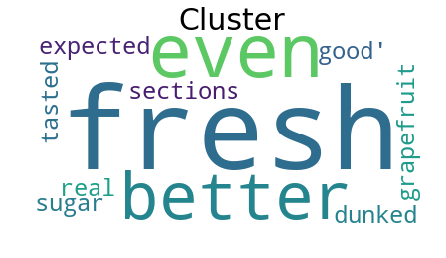

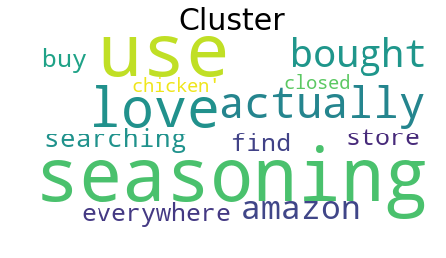

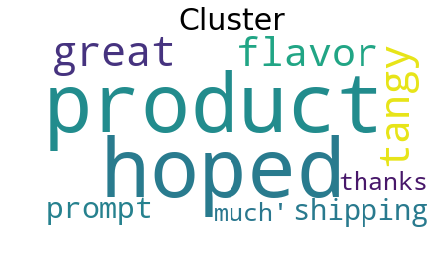

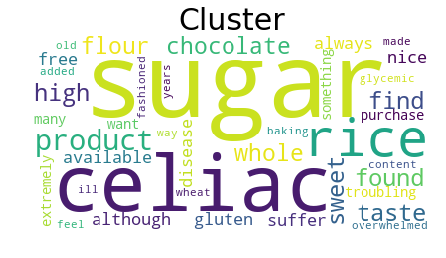

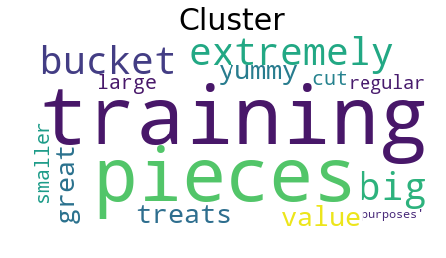

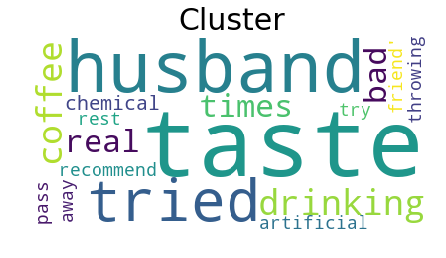

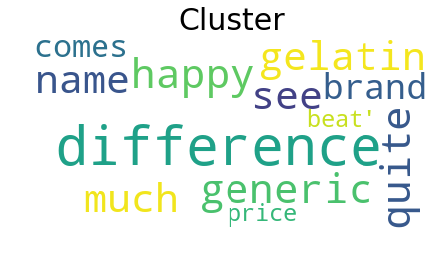

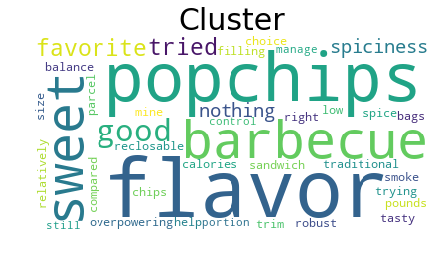

In [69]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://stackoverflow.com/questions/41792471/installing-wordcloud-using-jupyter-notebook
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# To install wordcloud >>>> conda install -c conda-forge wordcloud 

from wordcloud import WordCloud
def cloud(cluster_new):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster_new)))
    plt.figure(figsize = (6, 7), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show()
for cl in cluster:
    cloud(cl)

Observation(s):

1. Here we have 14 clusters.
2. All clusters are showing different - different items.
3. Cluseter 2 is showing clusters Hot Drinks related words(Tea, Coffee, Price). Cluseter 6 is showing clusters of amarican cities(America,Brazil,Place). Cluseter 8 is showing clusters of online shoping related words(Amazon, Seasoning, Store).Cluseter 4 is showing clusters of Chocolate related words(Sugar, Chocolate, Taste).

### [5.6] Function that returns most similar words for a given word.

In [61]:
from sklearn.metrics.pairwise import cosine_similarity
def similar_word_10(word):
    similarity = cosine_similarity(occ_matrix_2000)
    word_vect = similarity[top_2000_words.index(word)]
    print("Similar Word to",word)
    index = word_vect.argsort()[::-1][1:11]
    for j in range(len(index)):
        print((j+1),"Word",top_2000_words[index[j]] ,"is similar to",word,"\n")

In [62]:
similar_word_10(top_2000_words[1])

Similar Word to absolute
1 Word favorite is similar to absolute 

2 Word best is similar to absolute 

3 Word ever is similar to absolute 

4 Word not is similar to absolute 

5 Word far is similar to absolute 

6 Word tried is similar to absolute 

7 Word flavor is similar to absolute 

8 Word earth is similar to absolute 

9 Word coffees is similar to absolute 

10 Word one is similar to absolute 



# [6] Conclusions

Truncated Singular Value Decomposition (SVD) is a matrix factorization technique. 
           Then We have calculated co-occurrence matrix.It is a tool to store the count of how often a particular pair of things occurred together. Co-occurence matrix have specific entities in rows and entities in columns .Number of times each entities in rows appears in same context as each entities in columns.
           Then we find optimal value for number of components. where I observed 150 components.
           Then I apply k-means clustering and obtained 14 clusters.Then I represent obained clusters by word cloud and each cluster is perfctly seprated from other cluster. we have 14 clusters in WordCloud.All clusters are showing different - different items. Cluseter 2 is showing clusters Hot Drinks related words(Tea, Coffee, Price). Cluseter 6 is showing clusters of amarican cities(America,Brazil,Place). Cluseter 8 is showing clusters of online shoping related words(Amazon, Seasoning, Store).Cluseter 4 is showing clusters of Chocolate related words(Sugar, Chocolate, Taste).

I have optimal value  that I obtained for number of components = 150 & number of clusters = 14.